<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [3]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8
To: /content/clothing_ecommerce_reviews.csv
100%|██████████| 8.48M/8.48M [00:00<00:00, 31.5MB/s]


In [4]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [5]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


In [6]:
np.unique(df_reviews['Rating'])

array([0, 1, 2, 3, 4])

In [7]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase

Procentajes

In [8]:
rows, columns = df_reviews.shape
100*df_reviews['Rating'].value_counts()/(rows)

4    55.386246
3    21.677488
2    12.468531
1     6.841571
0     3.626165
Name: Rating, dtype: float64

Valores totales

In [9]:
df_reviews.Rating.value_counts()

4    12540
3     4908
2     2823
1     1549
0      821
Name: Rating, dtype: int64

Balanceo, tomamos como referencia n= 2500 para bajar los rantings 3 y 4

In [10]:
rating_4 = df_reviews[df_reviews.Rating ==4]
rating_3 = df_reviews[df_reviews.Rating ==3]
rating_2 = df_reviews[df_reviews.Rating ==2]
rating_1 = df_reviews[df_reviews.Rating ==1]
rating_0 = df_reviews[df_reviews.Rating ==0]
rating_4_sample = rating_4.sample(n=2500)
rating_3_sample = rating_3.sample(n=2500)

In [11]:
df_data_reviews = pd.concat([rating_4_sample, rating_3_sample, rating_2, rating_1, rating_0 ], axis=0)
#Balanced data_fraud
df_data_reviews.Rating.value_counts()

2    2823
4    2500
3    2500
1    1549
0     821
Name: Rating, dtype: int64

In [12]:
df_data_reviews.head()

,Review Text,Rating
3379,I love this top! the arms fit slender but the ...,4
21225,The pullover is very light weight material so ...,4
20047,I am in love with these. bought the regular le...,4
11501,Love love love this sweater! lots of complimen...,4
9070,So happy with this jacket! i have looked for w...,4


In [13]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews

In [14]:
vect = df_data_reviews['Review Text'].values
vect.shape

(10193,)

In [15]:
print(vect)

['I love this top! the arms fit slender but the rest of the top is a nice loose fit. i love the navy blue one with the print, i normally don&#39;t like long tunics but it&#39;s so flattering even for my short frame! i&#39;m usually a medium on top and bought the medium which was perfect.'
 'The pullover is very light weight material so great for fall or spring. it hangs nicely in front and back and is slimming. i ordered a medium other than the sleeves are not as long on me as the model it fits perfectly.'
 'I am in love with these. bought the regular length last year and loved them despite the shortness (hit right above the ankle). that length looks good with ballet flats or tucked into boots. this year i bought the burgundy and the teal in the long length. i am 5\'7" and the long fit perfectly! they come to the bottom of my ankle without extra fabric. \r\nplease restock the "carbon" in the long length! i want to buy my 4th pair!'
 ...
 'I loved the print and fabric of this dress when

In [16]:
# Alumno: Cuantas reviews (rows) hay para evaluar?

In [17]:
len(vect)

10193

In [18]:
# Alumno: Concatenar todas las reviews para armar el corpus

In [19]:
# Concatenar todas las reviews para armar el corpus
corpus = ' '.join(vect)

In [20]:
# Alumno: ¿Cuál es la longitud de ese corpus?

In [21]:
len(corpus)

3224698

In [22]:
print(corpus[:2])

I 


In [23]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence

In [24]:
tokens = text_to_word_sequence(corpus, filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ')

In [25]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras

In [26]:
print(tokens[:20])

['i', 'love', 'this', 'top', 'the', 'arms', 'fit', 'slender', 'but', 'the', 'rest', 'of', 'the', 'top', 'is', 'a', 'nice', 'loose', 'fit', 'i']


In [27]:
# Alumno: ¿Cuántos tokens/palabras hay?

In [28]:
print(len(tokens))

645249


In [29]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words

In [30]:
t  = Tokenizer(
num_words= vocab_size,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token=None,
    analyzer=None)

In [31]:
t.fit_on_texts(tokens)

In [32]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario

Cantidad de palabras 10617

In [33]:
word_ix = t.word_index
print(word_ix)
print(len(word_ix))

{'the': 1, 'i': 2, 'it': 3, 'and': 4, 'a': 5, 'is': 6, 'this': 7, 'to': 8, 'in': 9, 'but': 10, 'on': 11, 'was': 12, 'of': 13, 'for': 14, 'so': 15, 'not': 16, 'with': 17, 'my': 18, 'dress': 19, 'that': 20, 't': 21, 's': 22, 'have': 23, 'very': 24, 'size': 25, 'like': 26, 'top': 27, 'me': 28, 'be': 29, 'fit': 30, 'love': 31, 'are': 32, 'too': 33, 'as': 34, 'm': 35, 'just': 36, 'would': 37, 'you': 38, 'fabric': 39, 'wear': 40, 'am': 41, 'they': 42, '5': 43, 'at': 44, 'small': 45, 'or': 46, 'great': 47, 'if': 48, 'up': 49, 'color': 50, 'ordered': 51, 'really': 52, 'look': 53, 'back': 54, 'more': 55, 'had': 56, 'an': 57, 'because': 58, 'out': 59, 'one': 60, 'will': 61, 'these': 62, 'when': 63, 'little': 64, '\r': 65, 'can': 66, 'than': 67, 'material': 68, 'cute': 69, 'shirt': 70, 'large': 71, 'much': 72, 'all': 73, 'well': 74, 'looks': 75, 'nice': 76, 'flattering': 77, 'also': 78, 'beautiful': 79, 'which': 80, 'soft': 81, 'bit': 82, 'them': 83, 'down': 84, 'sweater': 85, 'waist': 86, 'perfe

In [34]:
# Alumno: Convertir las palabras/tokens a números

In [35]:
sequence_tokens = t.texts_to_sequences(vect)

In [36]:
print(sequence_tokens[0][:10])

[2, 31, 7, 27, 1, 168, 30, 864, 10, 1]


In [37]:
# Alumno: Determinar cual es la oración más larga

In [38]:
max(len(s) for s in sequence_tokens)

113

In [39]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from tensorflow.keras.utils import pad_sequences
maxlen = 113

In [40]:
p = pad_sequences(
    sequence_tokens,
    maxlen=maxlen,
    dtype='int32',
    padding='pre',
    truncating='pre',
    value=0.0
)

In [41]:
# Alumno: Observar las dimensiones de la variable input

In [42]:
p.shape

(10193, 113)

In [43]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)

In [44]:
y = to_categorical(df_data_reviews['Rating'].values)
print(y.shape)

(10193, 5)


In [45]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split

In [46]:
X_train, X_test, y_train, y_test = train_test_split(p, y, test_size=0.2, random_state=42)

In [47]:
# Alumno: determinar la dimensiones de entrada y salida

In [48]:
in_shape = X_train.shape[1] # max input sentence len
out_shape = 5 # multyclass classification
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 113 , out_shape 5


### 2 - Entrenar el modelo con Embeddings + LSTM

In [49]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

In [50]:
model = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = 50 --> crear embeddings de tamaño 50
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_length=in_shape))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=out_shape, activation='softmax'))

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 113, 50)           100050    
                                                                 
 lstm (LSTM)                 (None, 113, 64)           29440     
                                                                 
 dropout (Dropout)           (None, 113, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 6

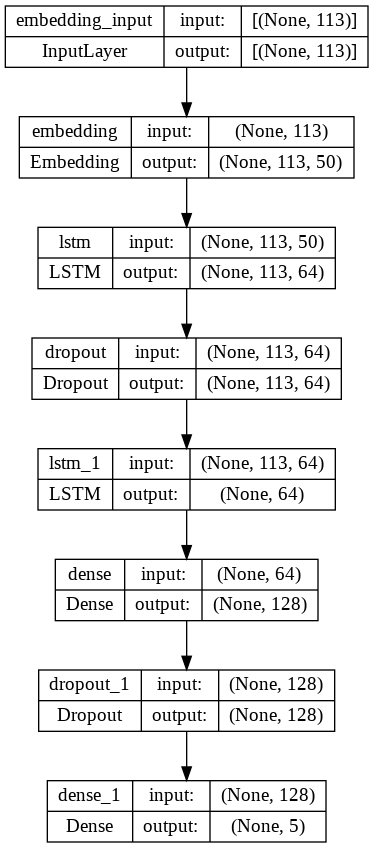

In [51]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [52]:
hist = model.fit(X_train, y_train, epochs=500, validation_split=0.2)

Epoch 1/500
204/204 [==============================] - 43s 164ms/step - loss: 1.3780 - accuracy: 0.3658 - val_loss: 1.2343 - val_accuracy: 0.4445
Epoch 2/500
204/204 [==============================] - 32s 155ms/step - loss: 1.1632 - accuracy: 0.4783 - val_loss: 1.2010 - val_accuracy: 0.4641
Epoch 3/500
204/204 [==============================] - 35s 171ms/step - loss: 1.0681 - accuracy: 0.5251 - val_loss: 1.1916 - val_accuracy: 0.4752
Epoch 4/500
204/204 [==============================] - 37s 179ms/step - loss: 1.0045 - accuracy: 0.5557 - val_loss: 1.1938 - val_accuracy: 0.4825
Epoch 5/500
204/204 [==============================] - 33s 162ms/step - loss: 0.9376 - accuracy: 0.5996 - val_loss: 1.2263 - val_accuracy: 0.4709
Epoch 6/500
204/204 [==============================] - 32s 158ms/step - loss: 0.8824 - accuracy: 0.6298 - val_loss: 1.3626 - val_accuracy: 0.4488
Epoch 7/500
204/204 [==============================] - 32s 159ms/step - loss: 0.8255 - accuracy: 0.6581 - val_loss: 1.3756 -

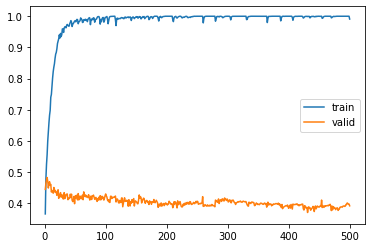

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [54]:
model.evaluate(X_test, y_test)

64/64 [==============================] - 2s 36ms/step - loss: 6.6259 - accuracy: 0.4022


[6.625930309295654, 0.4021579325199127]